In [447]:
# You may want to install "gprof2dot"
import io
from collections import Counter
import matplotlib.pyplot as plt

import numpy as np
import scipy.io
import sklearn.model_selection
import sklearn.tree
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin
import math
import csv

import pydot

eps = 1e-5  # a small number

In [460]:
# Q4.1 Decision Trees

class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes

    @staticmethod
    # A method that takes in some feature of the data, the labels and a threshold, and compute 
    # the information gain of a split using the threshold.
    def information_gain(X, y, thresh):
        # A method that takes in the labels of data stored at a node and compute the entropy 
        def gini_impurity(X, y):  
            d = dict()
            for i in range(len(X)):
                if y[i] in d:
                    d[y[i]] += 1
                else:
                    d[y[i]] = 1

            entropy = 0
            for key in d:
                p_c = d[key]/len(X)
                entropy -= p_c * math.log2(p_c)
            return entropy
    
        # Compute current entropy
        H_S = gini_impurity(X, y)
        
        # Compute entropy after splitting by threshold.
        left_X, left_y = [], []
        right_X, right_y = [], []
        for i in range(len(X)):
            if X[i] < thresh:
                left_X.append(X[i])
                left_y.append(y[i])
            else:
                right_X.append(X[i])
                right_y.append(y[i])
                
        # Compute information gain        
        H_l = gini_impurity(left_X, left_y)
        H_r = gini_impurity(right_X, right_y)
        H_after = (H_l * len(left_X) + H_r * len(right_X)) / len(X)
        return H_S - H_after

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    # Grows a decision tree by constructing nodes. Using the entropy and segmenter methods, it attempts 
    # to find a configuration of nodes that best splits the input data. This function figures out the split 
    # rules that each node should have and figures out when to stop growing the tree and insert a leaf node. 
    # There are many ways to implement this, but eventually your DecisionTree should store the root node 
    # of the resulting tree so you can use the tree for classification later on. Since the height of your 
    # DecisionTree shouldn’t be astronomically large (you may want to cap the height—if you do, the max height 
    # would be a hyperparameter), this method is best implemented recursively.
    def fit(self, X, y):
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node splits.
            
            thresh = np.array([np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10) for i in range(X.shape[1])])
            for i in range(X.shape[1]):
                gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])
                
            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    # Given a data point, traverse the tree to find the best label to classify the data point as. Start at 
    # the root node you stored and evaluate split rules at each node as you traverse until you reach a leaf node, 
    # then choose that leaf node’s label as your output label.
    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat

    def __repr__(self):
        if self.max_depth == 0:
            return "%s" % (self.pred)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())
    

In [431]:
# Q4.2 Random Forests

class RandomForest:
    def __init__(self, random_states, max_depth, feature_labels):
        self.random_states = random_states
        self.max_depth = max_depth
        self.feature_labels = feature_labels
        
    def fit_and_predict(self, training_X, training_y, test_X):
        predictions = [0] * len(test_X)
        for i in range(self.random_states):
            dt_titanic = DecisionTree(max_depth=3, feature_labels=features)
            rand_X = []
            rand_y = []
            for i in range(len(training_X)):
                randIndex = np.random.randint(len(training_X))
                rand_X.append(training_X[randIndex])
                rand_y.append(training_y[randIndex])
            dt = DecisionTree(self.max_depth, self.feature_labels)
            dt.fit(np.array(rand_X), np.array(rand_y))
            predictions += dt.predict(test_X)
        predictions *= 1/self.random_states
        return np.around(predictions)      

In [432]:
# Q4.3 Preprocessing

def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # Temporarily assign -1 to missing data
    data[data == ''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == '-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features

In [463]:
# Q4.4 Titanic Dataset

# Returns indices for training_labels and training_data that are set aside for validation and for training. Returns
# validation and training indices.
def shuffle_partition(data, count, total):
    np.random.seed(189)
    indices = np.arange(0, total, 1)
    np.random.shuffle(indices)
    return indices[0:count], indices[count:]

dataset = "titanic"
params = {
    "max_depth": 5,
    "min_samples_leaf": 10,
}
N = 100

# Load titanic data
path_train = './dataset/titanic/titanic_training.csv'
data = genfromtxt(path_train, delimiter=',', dtype=None, encoding=None)
path_test = './dataset/titanic/titanic_test_data.csv'
test_data = genfromtxt(path_test, delimiter=',', dtype=None, encoding=None)
y = data[1:, -1]  # label = survived
class_names = ["Died", "Survived"]
labeled_idx = np.where(y != '')[0]

y = np.array(y[labeled_idx])
y = y.astype(float).astype(int)

# Preprocessing dataset
X, onehot_features = preprocess(data[1:, :-1], onehot_cols=[1, 5, 7, 8])
X = X[labeled_idx, :]
Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
assert X.shape[1] == Z.shape[1]
titanic_features = list(data[0, :-1]) + onehot_features

# Split into training and validation sets.
X_titanic = X
y_titanic = y
Z_titanic = Z
titanic_val, titanic_training = shuffle_partition(X_titanic, 150,999)

In [464]:
# Q4.4 Spam dataset

dataset = "spam"
params = {
    "max_depth": 5,
    # "random_state": 6,
    "min_samples_leaf": 10,
}
N = 100


spam_features = [
    "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
    "height", "featured", "differ", "width", "other", "energy", "business", "message",
    "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
    "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
    "ampersand"
]
assert len(features) == 32

# Load spam data
path_train = './dataset/spam/spam_data.mat'
data = scipy.io.loadmat(path_train)
X = data['training_data']
y = np.squeeze(data['training_labels'])
Z = data['test_data']
class_names = ["Ham", "Spam"]

# Split into training and validation sets.
X_spam = X
y_spam = y
Z_spam = Z
spam_val, spam_training = shuffle_partition(X_titanic, 900,5280)

In [465]:
# Q4.4 Evaluation

# Calculates accuracy given predictions and labels.
def accuracy(X, y):
    total_correct = 0
    for i in range(len(X)):
        if X[i] == y[i]:
            total_correct += 1
    return total_correct/len(X)

# Train decision tree on titanic training data and predict on validation data.
dt_titanic = DecisionTree(max_depth=3, feature_labels=titanic_features)
dt_titanic.fit(X_titanic[titanic_training], y[titanic_training])
dt_titanic_predictions_training = dt_titanic.predict(X_titanic[titanic_training])
print("Decision Tree, Titanic, Training", accuracy(dt_titanic_predictions_training, y_titanic[titanic_training]))
dt_titanic_predictions_val = dt_titanic.predict(X_titanic[titanic_val])
print("Decision Tree, Titanic, Validataion", accuracy(dt_titanic_predictions_val, y_titanic[titanic_val]))

# Train random forest on titanic training data and predict on validation data.
rf_titanic = RandomForest(random_states=6, max_depth=3, feature_labels=titanic_features)
rf_titanic_predictions_training = rf_titanic.fit_and_predict(X_titanic[titanic_training], y_titanic[titanic_training], X_titanic[titanic_training])
print("Random Forest, Titanic, Training", accuracy(rf_titanic_predictions_training, y_titanic[titanic_training]))
rf_titanic_predictions_val = rf_titanic.fit_and_predict(X_titanic[titanic_training], y_titanic[titanic_training], X_titanic[titanic_val])
print("Random Forest, Titanic, Validation", accuracy(rf_titanic_predictions_val, y_titanic[titanic_val]))

# Train decision tree on spam training data and predict on validation data.
dt_spam = DecisionTree(max_depth=3, feature_labels=spam_features)
dt_spam.fit(X_spam[spam_training], y_spam[spam_training])
dt_spam_predictions_training = dt_spam.predict(X_spam[spam_training])
print("Decision Tree, Spam, Training", accuracy(dt_spam_predictions_training, y_spam[spam_training]))
dt_spam_predictions_val = dt_spam.predict(X_spam[spam_val])
print("Decision Tree, Spam, Validation", accuracy(dt_spam_predictions_val, y_spam[spam_val]))

# Train random forest on spam training data and predict on validation data.
rf_spam = RandomForest(random_states=6, max_depth=5, feature_labels=spam_features)
rf_spam_predictions_training = rf_spam.fit_and_predict(X_spam[spam_training], y_spam[spam_training], X_spam[spam_training])
print("Random Forest, Spam, Training", accuracy(rf_spam_predictions_training, y_spam[spam_training]))
rf_spam_predictions_val = rf_spam.fit_and_predict(X_spam[spam_training], y_spam[spam_training], X_spam[spam_val])
print("Random Forest, Spam, Validation", accuracy(rf_spam_predictions_val, y_spam[spam_val]))

Decision Tree, Titanic, Training 0.6219081272084805
Decision Tree, Titanic, Validataion 0.5533333333333333
Random Forest, Titanic, Training 0.8080094228504122
Random Forest, Titanic, Validation 0.7733333333333333
Decision Tree, Spam, Training 0.79337899543379
Decision Tree, Spam, Validation 0.8077777777777778
Random Forest, Spam, Training 0.8230593607305936
Random Forest, Spam, Validation 0.8322222222222222


In [413]:
# Q4.4 Write data to CSV file.

def create_file(prediction_file, file_name):
    header = ['Id', 'Category']
    data_file = []
    for i in range(len(prediction_file)):
        data_file.append([i+1, int(prediction_file[i])])
    with open(file_name, 'w', newline = '') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(header)
        writer.writerows(data_file)
    f.close()
    
# Test predictions for Titanic
test_predictions_titanic = rf_titanic.fit_and_predict(X_titanic, y_titanic, Z_titanic)
create_file(test_predictions_titanic, "titanic_predictions.csv")

# Test predictions for SPAM
test_predictions_spam = rf_spam.fit_and_predict(X_spam, y_spam, Z_spam)
create_file(test_predictions_spam, "spam_predictions.csv")

In [467]:
# Q4.5 Visualize decision tree for SPAM
dt_spam = DecisionTree(max_depth=3, feature_labels=spam_features)
dt_spam.fit(X_spam[spam_training], y[spam_training])
print(dt_spam)

[exclamation < 1e-05: [parenthesis < 1e-05: [creative < 1e-05: 0 | 1] | [money < 1e-05: 0 | 1]] | [money < 1e-05: [parenthesis < 1e-05: 1 | 0] | [energy < 1e-05: 1 | 0]]]


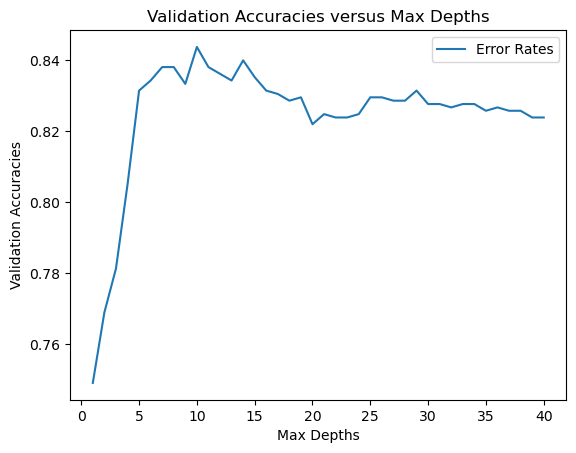

In [439]:
# Q4.5 Tuning maximum depth hyperparameter
# Create plot. 
def create_plot(num_train, training_accuracy, plot_title):
    x = num_train
    y = training_accuracy
    plt.title(plot_title) 
    plt.ylabel('Validation Accuracies') 
    plt.xlabel('Max Depths')  
    plt.plot(x, y, label = "Error Rates")
    plt.legend()
    plt.show()

spam_val, spam_training = shuffle_partition(X_titanic, 1056,5280)
depths = []
spam_val_accuracies = []
for depth in range(1, 41):
    dt_spam = DecisionTree(max_depth=depth, feature_labels=spam_features)
    dt_spam.fit(X_spam[spam_training], y[spam_training])
    dt_spam_predictions_val = dt_spam.predict(X_spam[spam_val])
    depths.append(depth)
    spam_val_accuracies.append(accuracy(dt_spam_predictions_val, y_spam[spam_val]))
    
create_plot(depths, spam_val_accuracies, "Validation Accuracies versus Max Depths")

In [466]:
# 4.6 Visualize decision tree for titanic
dt_titanic = DecisionTree(max_depth=3, feature_labels=titanic_features)
dt_titanic.fit(X_titanic[titanic_training], y[titanic_training])
print(dt_titanic)

[age < 43.99999888888889: [age < 8.777783333333332: [C < 1e-05: 0 | 0] | [sibsp < 2.6666700000000003: 0 | 0]] | [age < 67.99999666666666: [Q < 1e-05: 0 | 1] | [pclass < 1.00001: 0 | 0]]]
